## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [1]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

In [2]:
len(technical_features)

22

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [79]:
!pip install lightgbm

In [5]:
!pip install plotnine 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 54.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 43.5 MB/s eta 0:00:00


In [10]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 46.5 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [4]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [5]:
path = "/home/ebacigalupe/zrive-ds/zrive-ds/src/"
data_set = pd.read_feather(path + "module_5/financials_against_return.feather")

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [6]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [7]:
data_set.shape

(170483, 145)

Create the target:

In [8]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [9]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [10]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [17]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [11]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric 
             }
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [12]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [18]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    #print(model)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

In [19]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [20]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [21]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

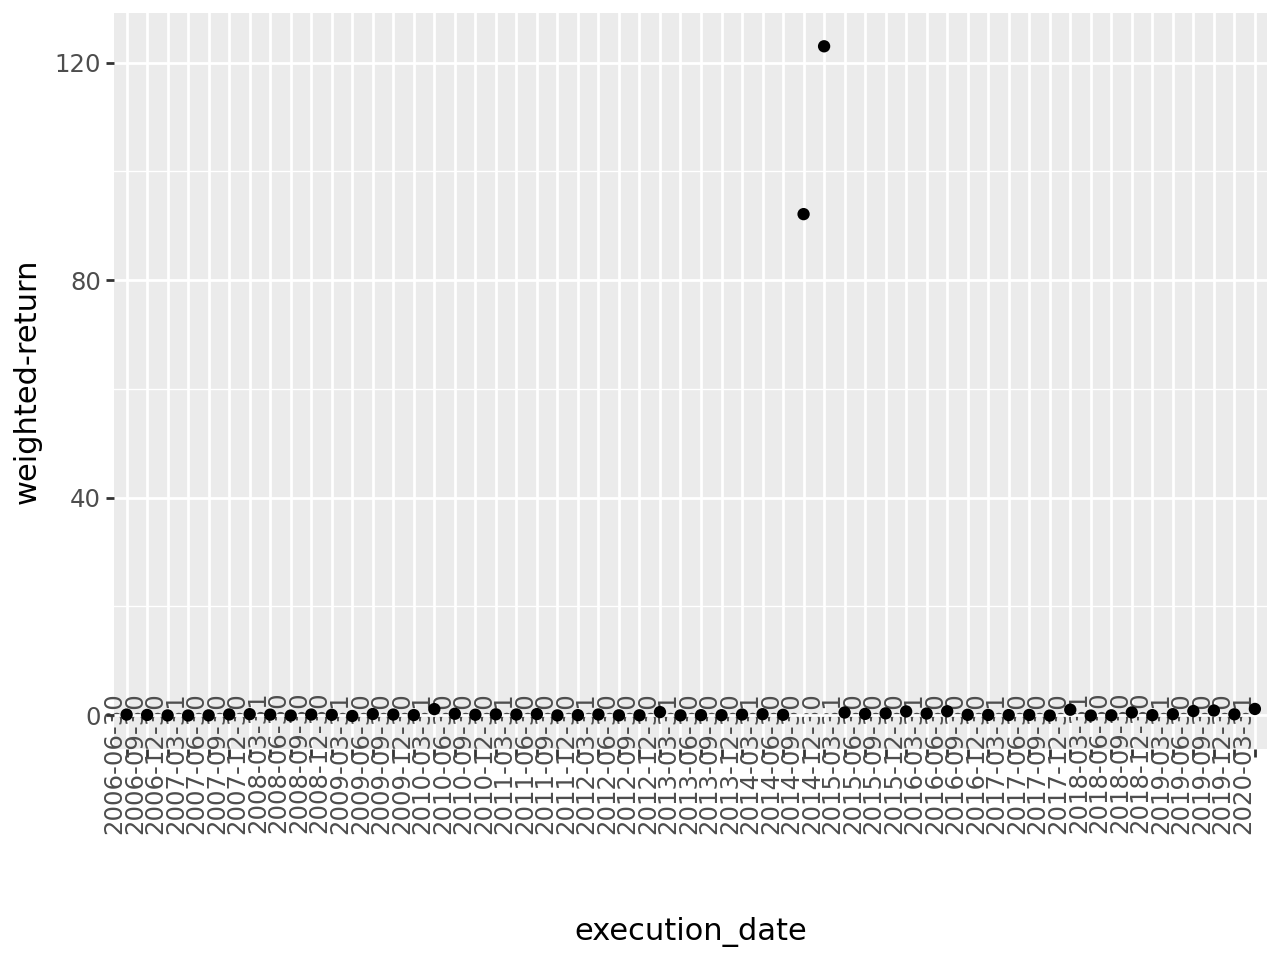

In [22]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



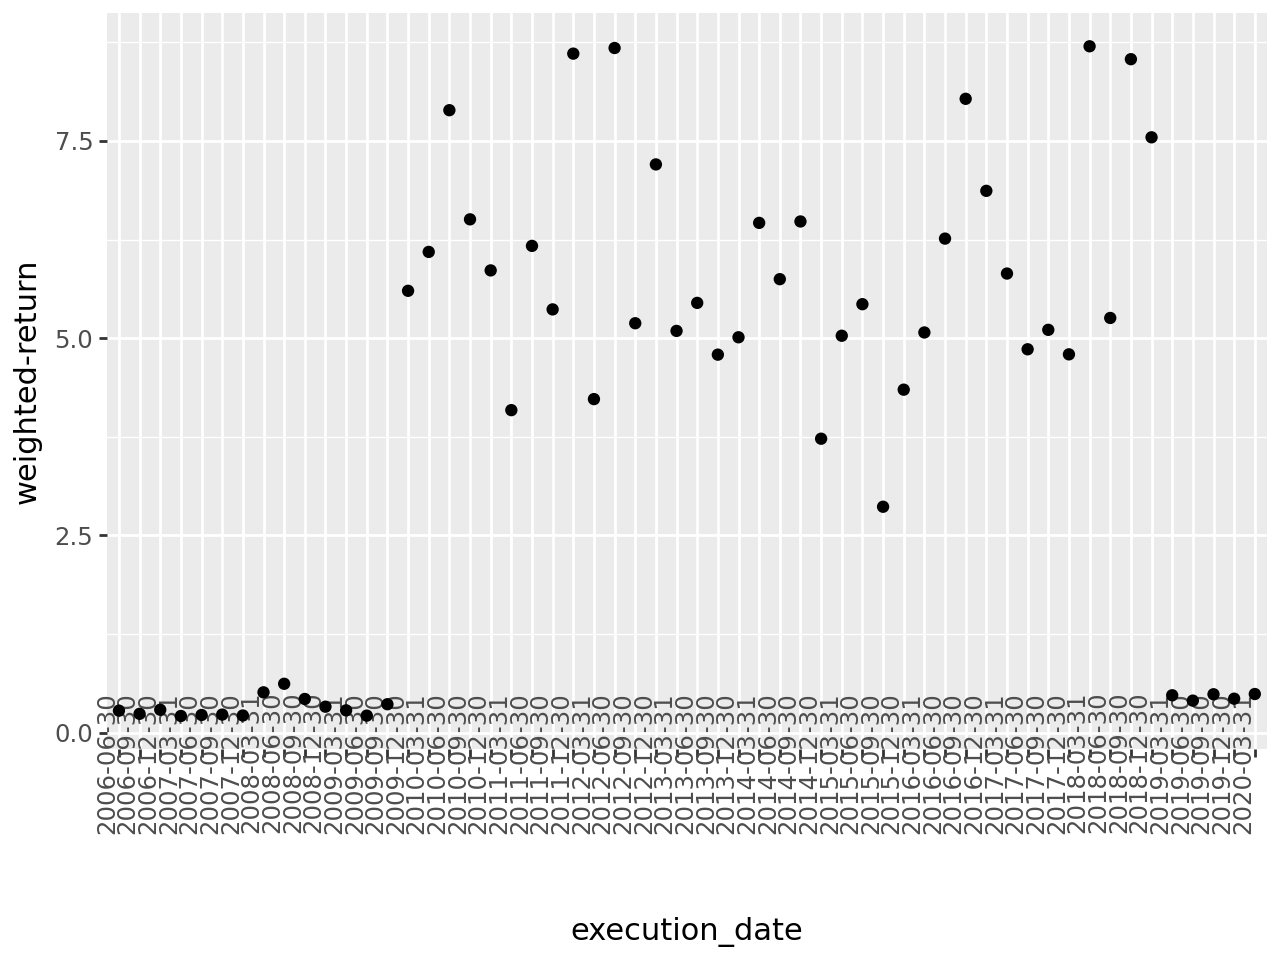

In [23]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [24]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


In [25]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

### Analyse, diagnose and improve the model

#### Deeper analyze the model:

Let's use other visualizations to deeper analyze the model. I'll combine results datasets to see them together in a plot. Besides that, I'll remove outliers for the visualization:

In [26]:
test_results_final_tree['Type'] = 'Test'
train_results_final_tree['Type'] = 'Train'

combined_data = pd.concat([test_results_final_tree, train_results_final_tree])
combined_data['execution_date'] = pd.to_datetime(combined_data['execution_date'])
combined_data = combined_data[combined_data['weighted-return'] <= 80]

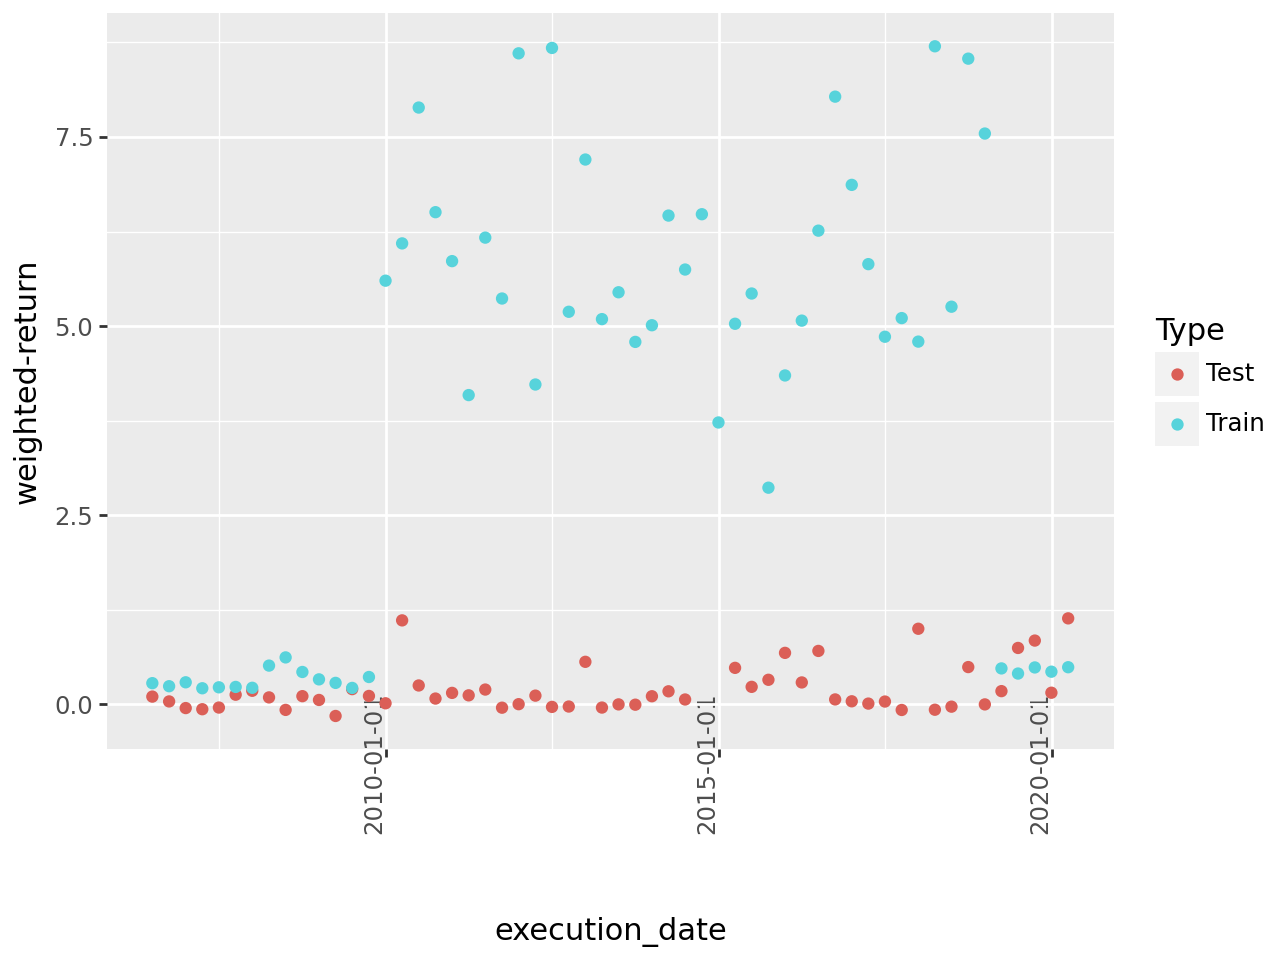

In [27]:
from plotnine import ggplot, aes, geom_point, theme, element_text

(ggplot(combined_data, aes(x='execution_date', y='weighted-return', color='Type'))
     + geom_point()
     + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1)))

The results can be divided into three periods:
* Model seems to works fine during firsts execution dates. Until 2010 aprox. train and test weighted-return follow same behaviour.
* During a second period (the longest one) between 2010 and end of 2019, the model outputs very different results between train and test. Train results have more dispersion and higher weighted-return values.
* After 2020, model looks like first period.

In all cases, the model seems to have high variance.

Logloss metric can also be plotted to evaluate classification performance along time:

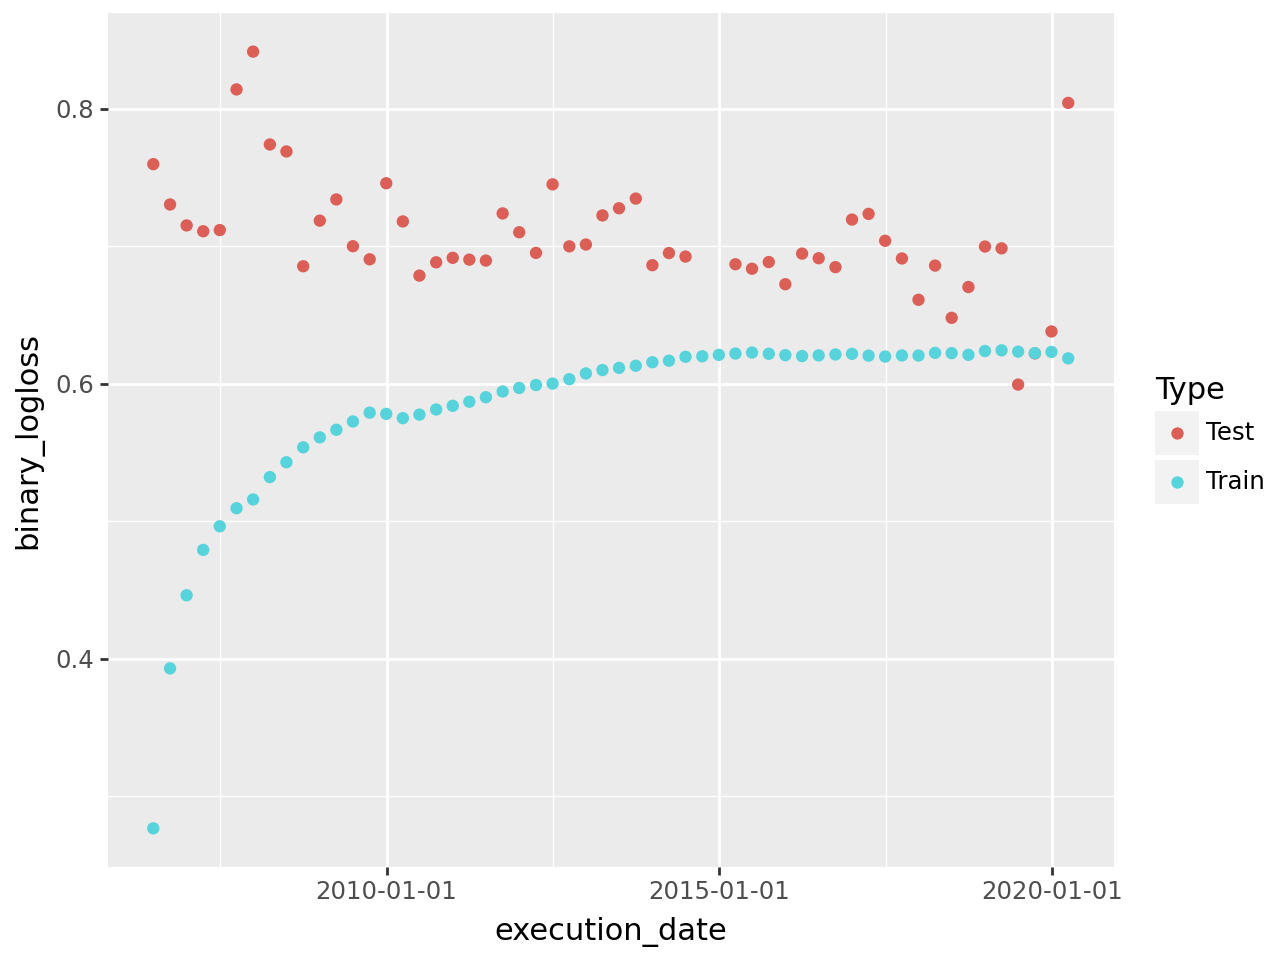

In [28]:
from plotnine import ggplot, aes, geom_line, labs, theme, element_text

p = ggplot(combined_data) + geom_point(aes(x='execution_date', y='binary_logloss', colour='Type'))
p

* Train: Model is worsen its performance for every execution_date. Logloss increases as the predicted probability diverges from the actual label
* Test: Although model slightly improves for every execution_date, its performance is not as good as expected from the start. 

At first place, suspicious features must be checked. Dataset contains a lot of features, which increases the dimensionality of the problem:

#### Suspicious features:

First, let's try to check on suspicious features. To do so, we will execute the model for one specific execution date and plot top 25 features by low to top importance:

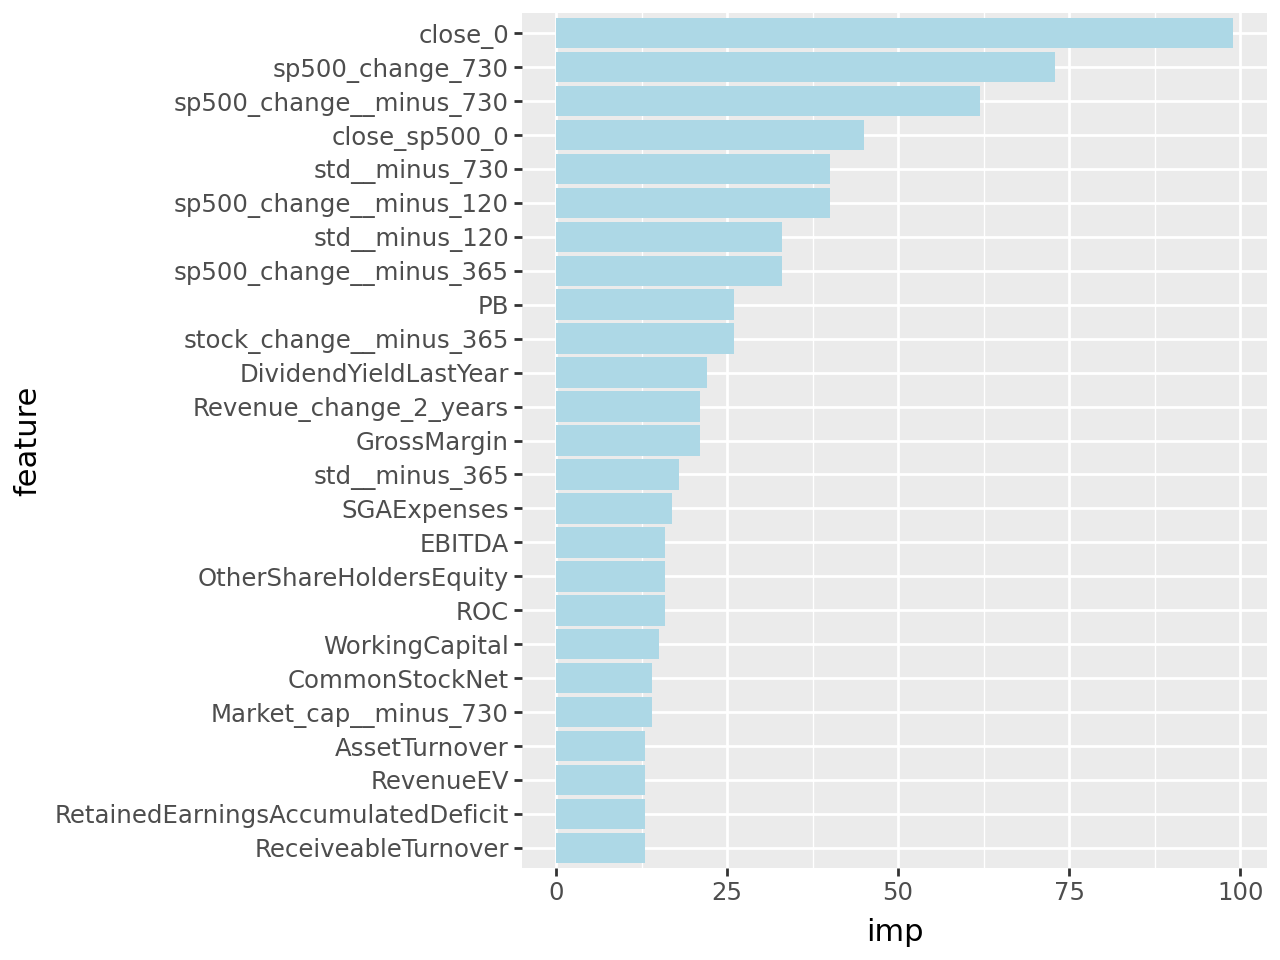

In [29]:
execution_date = '2016-06-30 00:00:00'

all_results = {}
all_predicted_tickers_list = []
all_models = {}

all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)

draw_feature_importance(model,top = 25)

Let's briefly comment some of the features as a hypotheis to improve the model:
* close_0: Price of the stock at execution date. Seems important, but that important? Basically is saying that if the price is low you'll have a high probability that the price is going up and viceversa. We could build a model just with that feature.
* sp500_change_730: % of change in the SP500 in the following 2 years. Since the goal is to have a better return than `SP500` in the following year, the model should't take into account this. We will remove it. Same for Revenue_change_2_years.
* close_sp500: Not sure about this, but this feature can be highly correlated with close_0. Need to check.


Correlation between columns of dataset must be checked. We filter the dataset by only numerical  and binary columns. The aim is to build a dataset with high-correlated pairs of variables:

In [30]:
label_col = 'diff_ch_sp500'
numerical_cols = data_set.select_dtypes(include=['int64', 'float64']).columns.drop(label_col, errors='ignore')
binary_cols = [col for col in numerical_cols if data_set[col].nunique() == 2]

cols = list(set(numerical_cols.tolist() + binary_cols))

In [31]:
corr_matrix = data_set[cols].corr()

corr_pairs = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        col1 = cols[i]
        col2 = cols[j]
        corr_coef = corr_matrix.iloc[i, j]
        corr_pairs.append({'column_correlated_1': col1, 'column_correlated_2': col2, 'corr_coef': corr_coef})

corr_df = pd.DataFrame(corr_pairs)
corr_df = corr_df.sort_values(by='corr_coef', ascending=False).reset_index(drop=True)

In [32]:
high_corr_df= corr_df[(corr_df["corr_coef"] < (-0.7)) | (corr_df["corr_coef"] > (0.7))]
high_corr_df

,column_correlated_1,column_correlated_2,corr_coef
0,EBITMargin,OperatingMargin,0.999997
1,stock_change_div_365,stock_change_365,0.999988
2,TotalAssets,TotalLiabilitiesAndShareHoldersEquity,0.999960
3,stock_change_730,stock_change_div_730,0.999951
4,TotalLong_minus_TermAssets,PropertyPlantAndEquipment,0.999848
...,...,...,...
9865,OtherOperatingIncomeOrExpenses,GrossProfit,-0.706278
9866,NetCurrentDebt,NetLong_minus_TermDebt,-0.868292
9867,Long_minus_termDebtCapital,ROI_minus_ReturnOnInvestment,-0.925366
9868,EBITDAEV,RDEV,-0.955481


There seems to be a high number of correlated variables. We will delete some of them:

In [33]:
col_list_keep = []
col_list_2 = []
for col1, col2 in zip(high_corr_df["column_correlated_1"], high_corr_df["column_correlated_2"]):
    col_list_keep.append(col1)
    col_list_2.append(col2)

col_list_drop = []
for i in col_list_2:
    if i not in col_list_keep:
        col_list_drop.append(i)

len(col_list_drop)

66

Also, we will delete variables containing 'change_730' or 'change_2_years'. These features contain information beyond our scope since we only want to predict one year ahead.

In [34]:
future_cols = data_set.columns[data_set.columns.str.contains('change_730|change_2_years')]

In [35]:
for i in future_cols:
    if i not in col_list_drop:
        col_list_drop.append(i)

In [36]:
len(col_list_drop)

75

Now, get_columns_to_remove() function will be modified in order to delete also correlated columns:

In [37]:
columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]

In [38]:
for i in columns_to_remove:
    if i not in col_list_drop:
        col_list_drop.append(i)

columns_to_remove = col_list_drop
len(columns_to_remove)

91

In [39]:
def get_columns_to_remove():
    columns_to_remove        
    return columns_to_remove

Re running the model again with new variables:

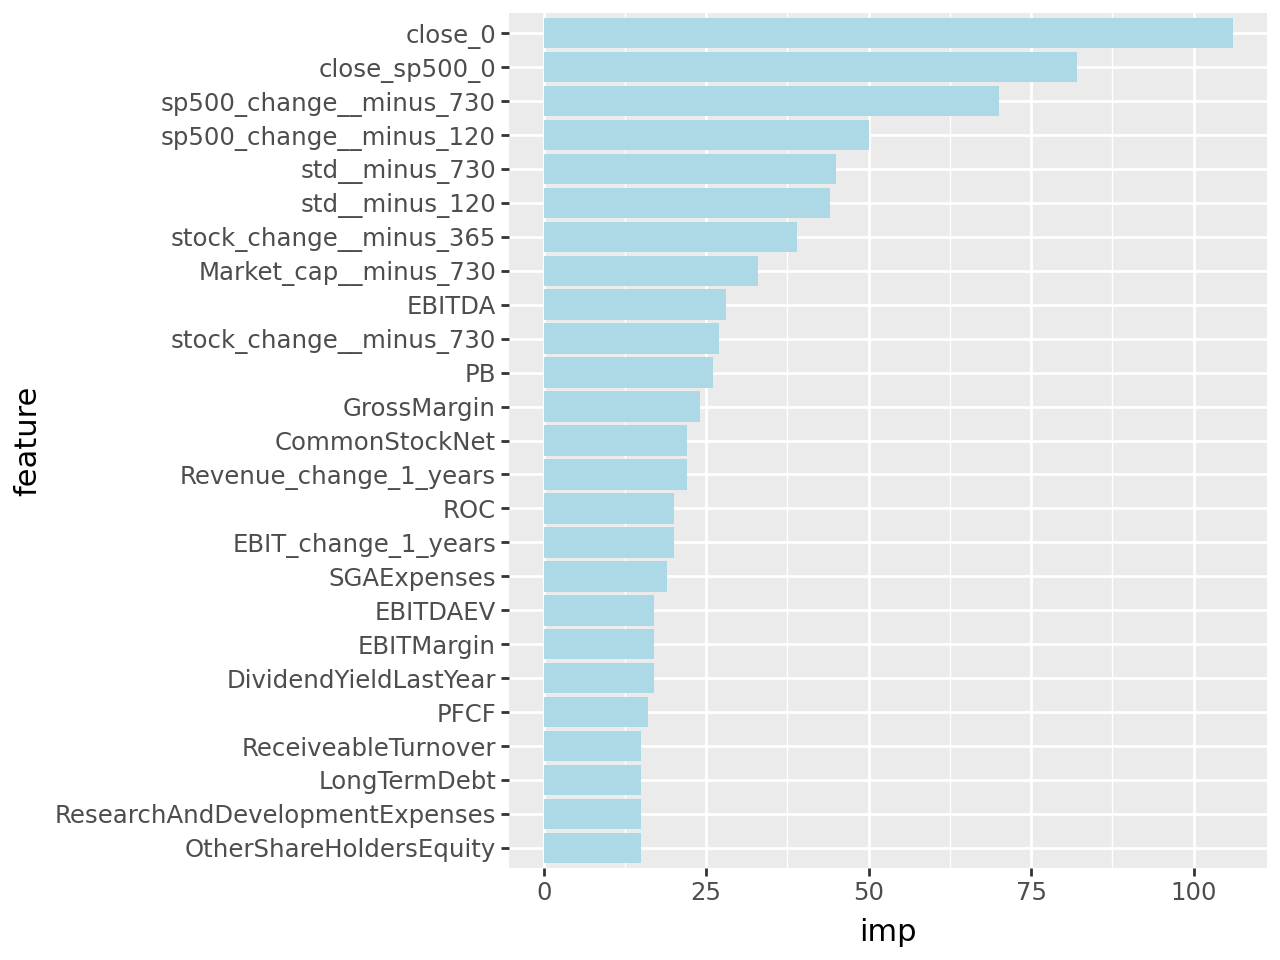

In [40]:
execution_date = '2016-06-30 00:00:00'

all_results = {}
all_predicted_tickers_list = []
all_models = {}

all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

draw_feature_importance(model,top = 25)

Feature importance sorting has changed, so the model performance may has improve? Lets check

In [41]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    #print(model)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

In [42]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

I'll again combine both datasets to see them together in a plot and I'll again remove outliers:

In [43]:
test_results_final_tree['Type'] = 'Test'
train_results_final_tree['Type'] = 'Train'

combined_data = pd.concat([test_results_final_tree, train_results_final_tree])
combined_data['execution_date'] = pd.to_datetime(combined_data['execution_date'])
combined_data = combined_data[combined_data['weighted-return'] <= 80]

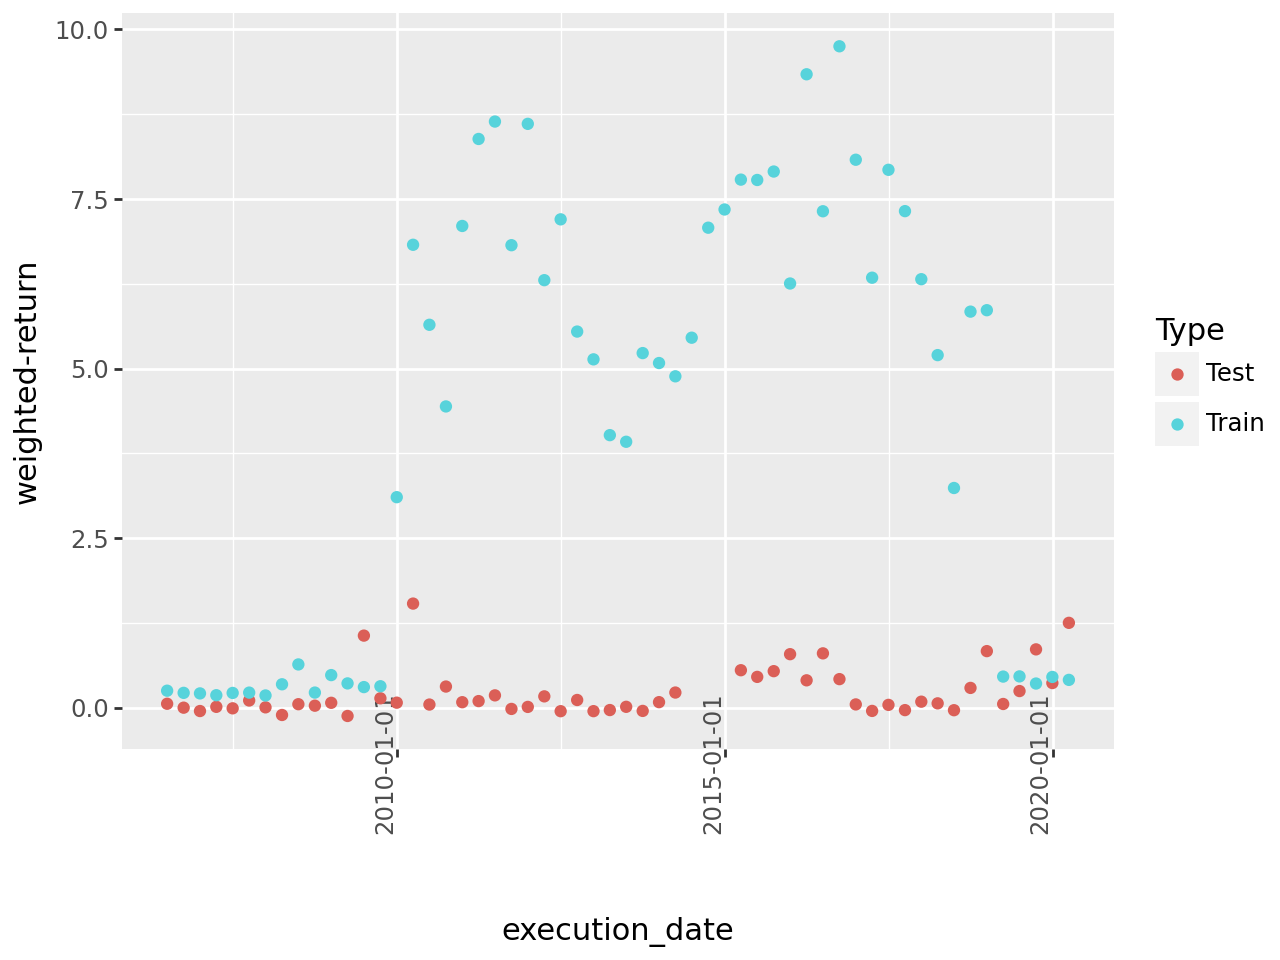

In [44]:
(ggplot(combined_data, aes(x='execution_date', y='weighted-return', color='Type'))
     + geom_point()
     + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1)))

Seems not to improve much. Result is quite similar as before.

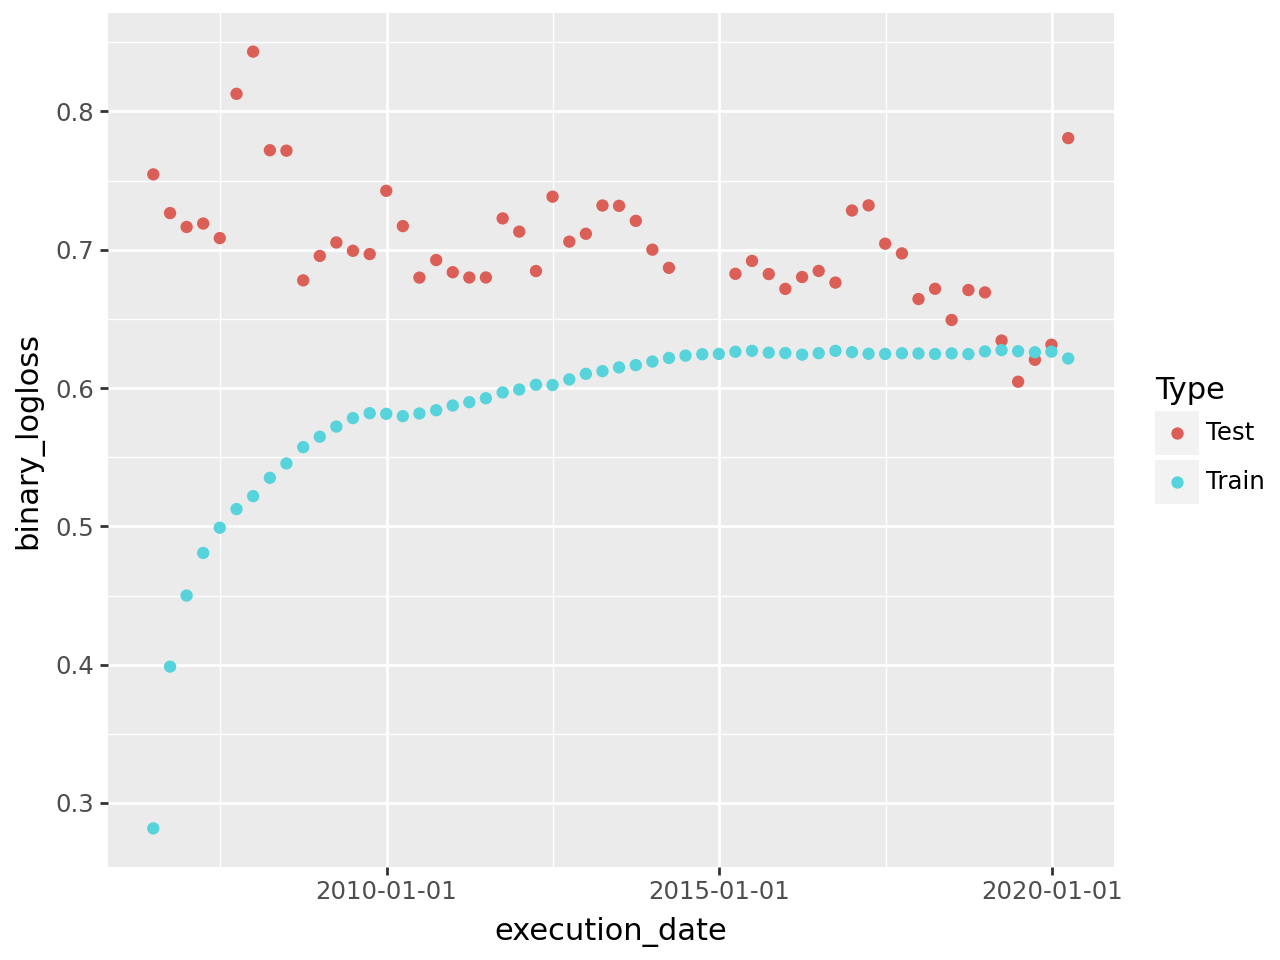

In [45]:
from plotnine import ggplot, aes, geom_line, labs, theme, element_text

p = ggplot(combined_data) + geom_point(aes(x='execution_date', y='binary_logloss', colour='Type'))
p

Also the performance has not improved much.

Let's also try with permutation feature importance since it is more trustfull for tree models:

In [46]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from plotnine import ggplot, aes, geom_col, coord_flip, scale_x_discrete
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [47]:
def draw_permutation_feature_importance(model, X, y, top=15):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=1, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()[-top:]
    
    feature_names = np.array(X.columns)
    feature_importance = pd.DataFrame({
        "feature": feature_names[perm_sorted_idx],
        "imp": result.importances_mean[perm_sorted_idx]
    })

    feature_importance = feature_importance.sort_values("imp", ascending=True)
    
    plot = ggplot(feature_importance, aes(x="feature", y="imp")) + geom_col(fill="lightblue") + coord_flip() + scale_x_discrete(limits=feature_importance["feature"])
    
    return plot

In [48]:
def train_model_feature_permutation(train_set, test_set, n_estimators=300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    model = LGBMClassifier(
        n_estimators=n_estimators,
        random_state=1,
        n_jobs=10
    )
    
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              eval_metric='binary_logloss')
    
    eval_result = model.evals_result_
    
    return model, eval_result, X_train, X_test, y_test

In [49]:
execution_date = '2016-06-30 00:00:00'
train_set, test_set = split_train_test_by_period(data_set, execution_date)
model, eval_result, X_train, X_test, y_test = train_model_feature_permutation(train_set, test_set, n_estimators=300)

[LightGBM] [Info] Number of positive: 42797, number of negative: 43114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24087
[LightGBM] [Info] Number of data points in the train set: 85911, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498155 -> initscore=-0.007380
[LightGBM] [Info] Start training from score -0.007380


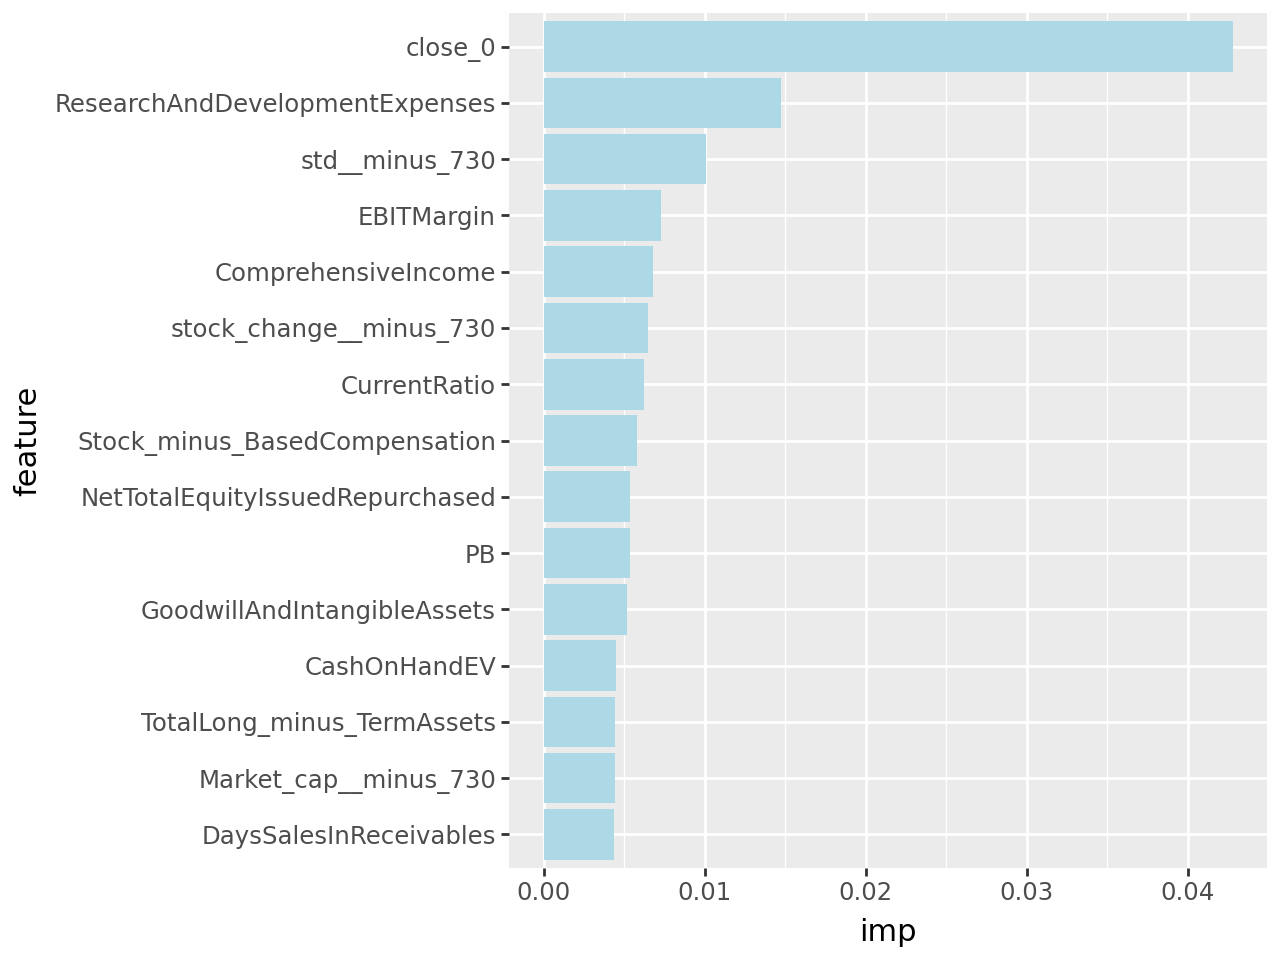

In [50]:
draw_permutation_feature_importance(model, X_test, y_test, top=15)

Using this method, we can see that most important features has significaly changed. However, close_0 remain the most relevant feature for the model. Let's try using SHAP to helps us to understand the concrete factors affecting the prediction:

In [131]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 KB 12.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 49.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 45.7 MB/s eta 0:00:0000:0100:01


In [133]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 13.9 MB/s eta 0:00:0000:0100:01


In [51]:
import xgboost
import shap

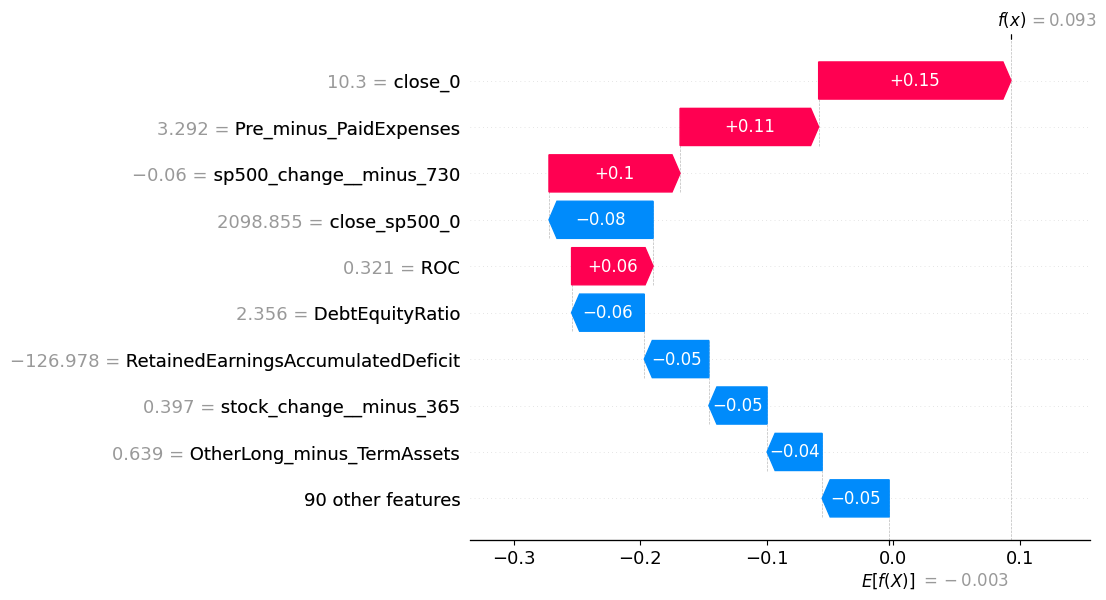

In [52]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])

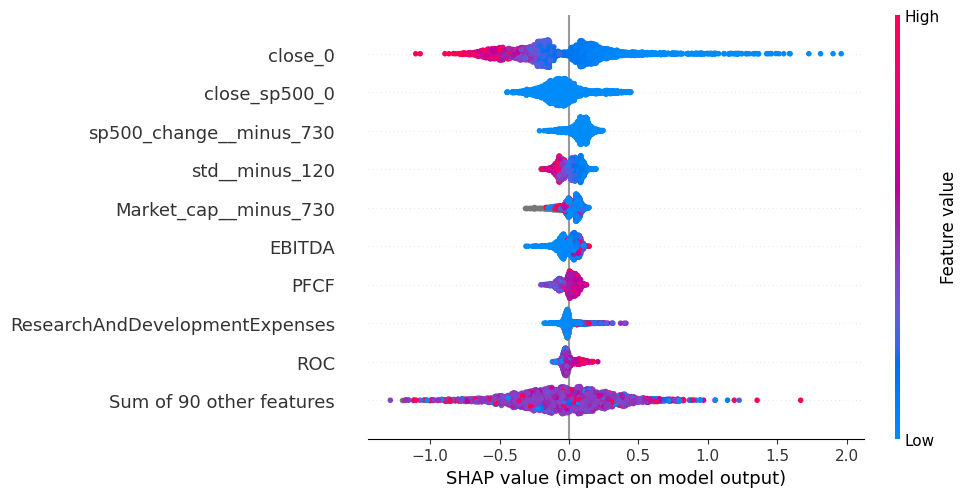

In [53]:
shap.plots.beeswarm(shap_values)

These charts reveal that the lower the price of the stock value on execution date is, the most probable it is for that stock to improve SP500 and viceversa, as we suggested before.

Now, let's change the parameters of the model to try to improve its performance. I'll use dataset with deleted fetures:

#### Changing parameters:

Different values for n_estimators must be evaluated. For each one, average logloss is going to be calculated to give us an idea of its performance. Model will be run for one every four execution dates to try to make computing time shorter:

In [72]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

n_estimators_range = [100, 200, 300, 400, 500]

best_n_estimators = None
best_score = float('inf')

for n_estimators in n_estimators_range:
    print(f"Testing n_estimators = {n_estimators}")
    temp_all_results = {}
    temp_all_predicted_tickers_list = []
    temp_all_models = {}
    
    for i, execution_date in enumerate(execution_dates):
        if i % 4 == 0: 
            temp_all_results, temp_all_predicted_tickers_list, temp_all_models, model, X_train, X_test = run_model_for_execution_date(
                execution_date, temp_all_results, temp_all_predicted_tickers_list, temp_all_models, n_estimators, False
            )
    
    avg_logloss = np.mean([np.mean(result['valid_0']['binary_logloss']) for result in temp_all_results.values()])
    print(f"Average logloss for n_estimators={n_estimators}: {avg_logloss}")
    
    if avg_logloss < best_score:
        best_score = avg_logloss
        best_n_estimators = n_estimators
        all_results = temp_all_results
        all_predicted_tickers_list = temp_all_predicted_tickers_list
        all_models = temp_all_models

all_predicted_tickers = pd.concat(all_predicted_tickers_list)

print(f"Best n_estimators: {best_n_estimators} with average logloss: {best_score}")


Testing n_estimators = 100
Average logloss for n_estimators=100: 0.7027516948193393
Testing n_estimators = 200
Average logloss for n_estimators=200: 0.7159846417948109
Testing n_estimators = 300
Average logloss for n_estimators=300: 0.7288686204355417
Testing n_estimators = 400
Average logloss for n_estimators=400: 0.7415601279183945
Testing n_estimators = 500
Average logloss for n_estimators=500: 0.7542690379589565
Best n_estimators: 100 with average logloss: 0.7027516948193393


The trend is that the average loss increases as n_estimators value increases. The higher the value, the worse the prediction. Let's give another chance to this approach by changing n_estimators_range from 10 to 50:

In [73]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

n_estimators_range = [10, 20, 30, 40, 50]

best_n_estimators = None
best_score = float('inf')

for n_estimators in n_estimators_range:
    print(f"Testing n_estimators = {n_estimators}")
    temp_all_results = {}
    temp_all_predicted_tickers_list = []
    temp_all_models = {}
    
    for i, execution_date in enumerate(execution_dates):
        if i % 4 == 0: 
            temp_all_results, temp_all_predicted_tickers_list, temp_all_models, model, X_train, X_test = run_model_for_execution_date(
                execution_date, temp_all_results, temp_all_predicted_tickers_list, temp_all_models, n_estimators, False
            )
    
    avg_logloss = np.mean([np.mean(result['valid_0']['binary_logloss']) for result in temp_all_results.values()])
    print(f"Average logloss for n_estimators={n_estimators}: {avg_logloss}")
    
    if avg_logloss < best_score:
        best_score = avg_logloss
        best_n_estimators = n_estimators
        all_results = temp_all_results
        all_predicted_tickers_list = temp_all_predicted_tickers_list
        all_models = temp_all_models

all_predicted_tickers = pd.concat(all_predicted_tickers_list)

print(f"Best n_estimators: {best_n_estimators} with average logloss: {best_score}")

Testing n_estimators = 10
Average logloss for n_estimators=10: 0.692179402196475
Testing n_estimators = 20
Average logloss for n_estimators=20: 0.6924727725321257
Testing n_estimators = 30
Average logloss for n_estimators=30: 0.6934542550285049
Testing n_estimators = 40
Average logloss for n_estimators=40: 0.6946515882551969
Testing n_estimators = 50
Average logloss for n_estimators=50: 0.6959626483594471
Best n_estimators: 10 with average logloss: 0.692179402196475


The average log loss is lower than before, but now the differences between 10 and 50 n_estimators are minimum. We can say that low number of estimators perform better than higher number, though.

Now, let's tune other parameters aiming to reduce variance of the model:
* num_leaves
* max_depth
* min_data_in_leaf

In [54]:
def train_model(train_set, test_set, n_estimators=300, num_leaves=31, max_depth=-1, min_data_in_leaf=20):
    columns_to_remove = get_columns_to_remove()
    X_train = train_set.drop(columns=columns_to_remove, errors="ignore")
    X_test = test_set.drop(columns=columns_to_remove, errors="ignore")
    y_train = train_set["target"]
    y_test = test_set["target"]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    eval_result = {}
    params = {
        "random_state": 1,
        "verbosity": -1,
        "n_jobs": 10,
        "n_estimators": n_estimators,
        "objective": 'binary',
        "metric": 'binary_logloss',
        "num_leaves": num_leaves,
        "max_depth": max_depth,
        "min_data_in_leaf": min_data_in_leaf
    }
    model = lgb.train(params=params, train_set=lgb_train,
                      valid_sets=[lgb_test, lgb_train],
                      feval=[top_wt_performance],
                      callbacks=[lgb.record_evaluation(eval_result=eval_result)])
    return model, eval_result, X_train, X_test

In [55]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_estimators, num_leaves, max_depth, min_data_in_leaf, include_nulls_in_test=False):
    global train_set
    global test_set
    train_set, test_set = split_train_test_by_period(data_set, execution_date, include_nulls_in_test=include_nulls_in_test)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None
    X_train = None
    X_test = None
    if train_size > 0 and test_size > 0:
        model, evals_result, X_train, X_test = train_model(train_set, test_set, n_estimators=n_estimators, num_leaves=num_leaves, max_depth=max_depth, min_data_in_leaf=min_data_in_leaf)
        test_set['prob'] = model.predict(X_test)
        predicted_tickers = test_set.sort_values('prob', ascending=False)
        predicted_tickers["execution_date"] = execution_date
        all_results[execution_date] = evals_result
        all_models[execution_date] = model
        all_predicted_tickers_list.append(predicted_tickers)
    return all_results, all_predicted_tickers_list, all_models, model, X_train, X_test

In [88]:
n_estimators = 50
num_leaves = 70
max_depth = 7
min_data_in_leaf = 50

In [89]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    #print(model)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,num_leaves,max_depth,min_data_in_leaf,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

In [93]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

test_results_final_tree['Type'] = 'Test'
train_results_final_tree['Type'] = 'Train'

combined_data = pd.concat([test_results_final_tree, train_results_final_tree])
combined_data['execution_date'] = pd.to_datetime(combined_data['execution_date'])
combined_data = combined_data[combined_data['weighted-return'] <= 60]

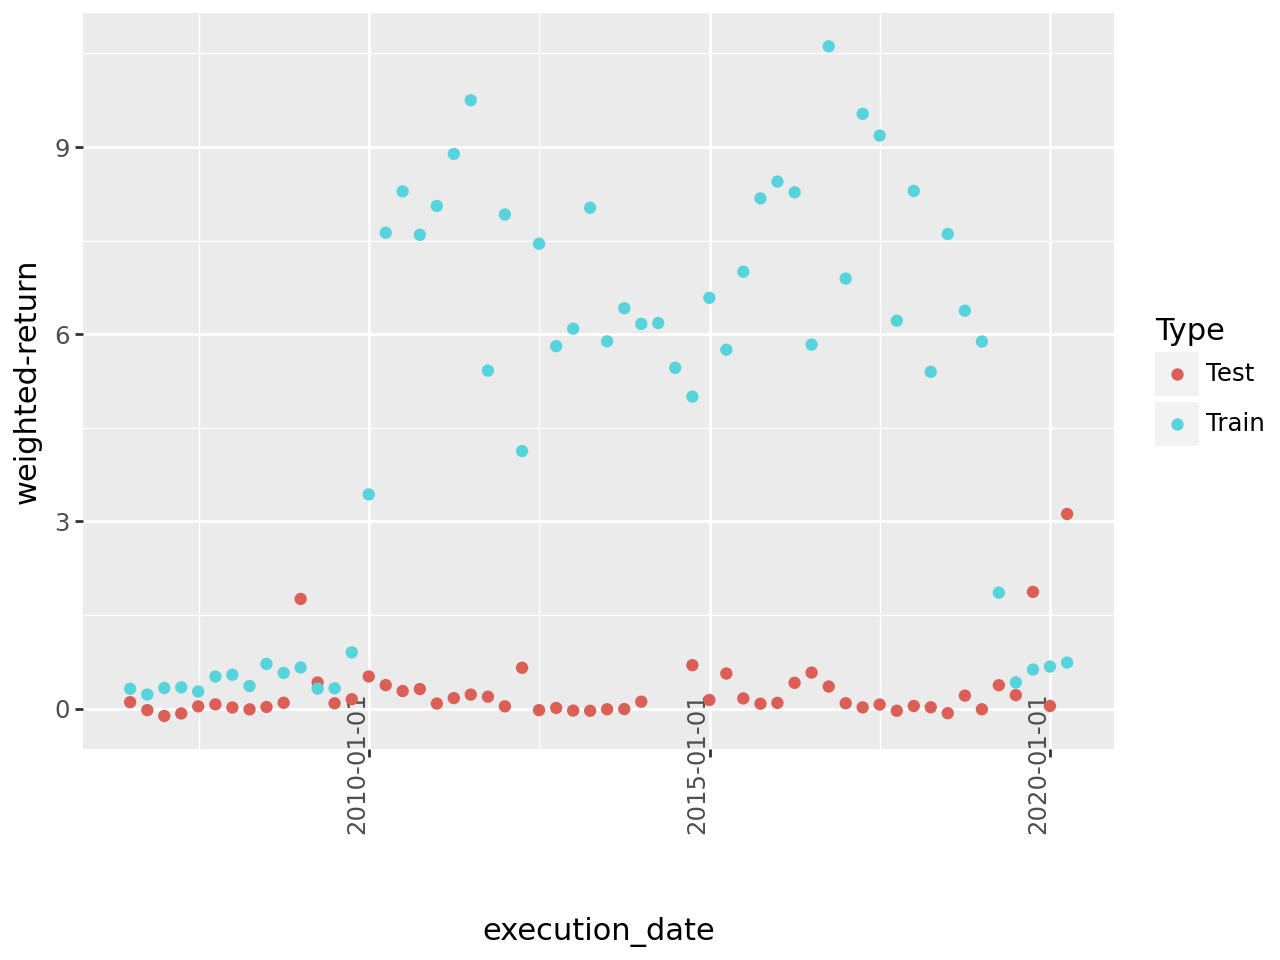

In [94]:
(ggplot(combined_data, aes(x='execution_date', y='weighted-return', color='Type'))
     + geom_point()
     + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1)))

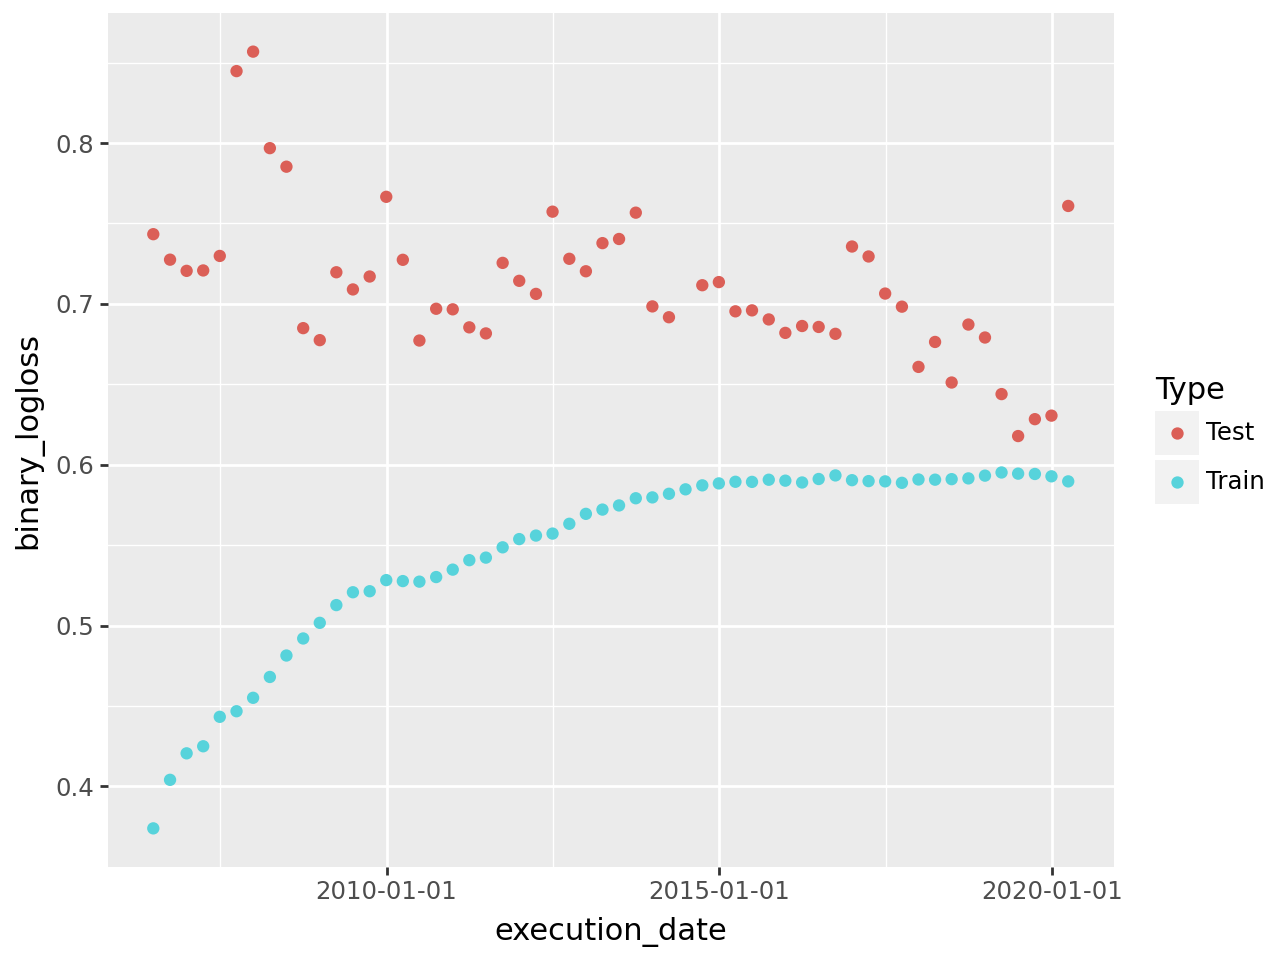

In [92]:
p = ggplot(combined_data) + geom_point(aes(x='execution_date', y='binary_logloss', colour='Type'))
p  

Despite results in first plot seem not to improve, second plot reveals that the performance of the model has slightly increased. Optimizing this parameters seems the way to improve the overall model. Let's try again with parameters with lower values to see if it keeps improving:

In [96]:
n_estimators = 30
num_leaves = 10
max_depth = 4
min_data_in_leaf = 60

In [97]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    #print(model)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,num_leaves,max_depth,min_data_in_leaf,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

In [98]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

test_results_final_tree['Type'] = 'Test'
train_results_final_tree['Type'] = 'Train'

combined_data = pd.concat([test_results_final_tree, train_results_final_tree])
combined_data['execution_date'] = pd.to_datetime(combined_data['execution_date'])
combined_data = combined_data[combined_data['weighted-return'] <= 60]

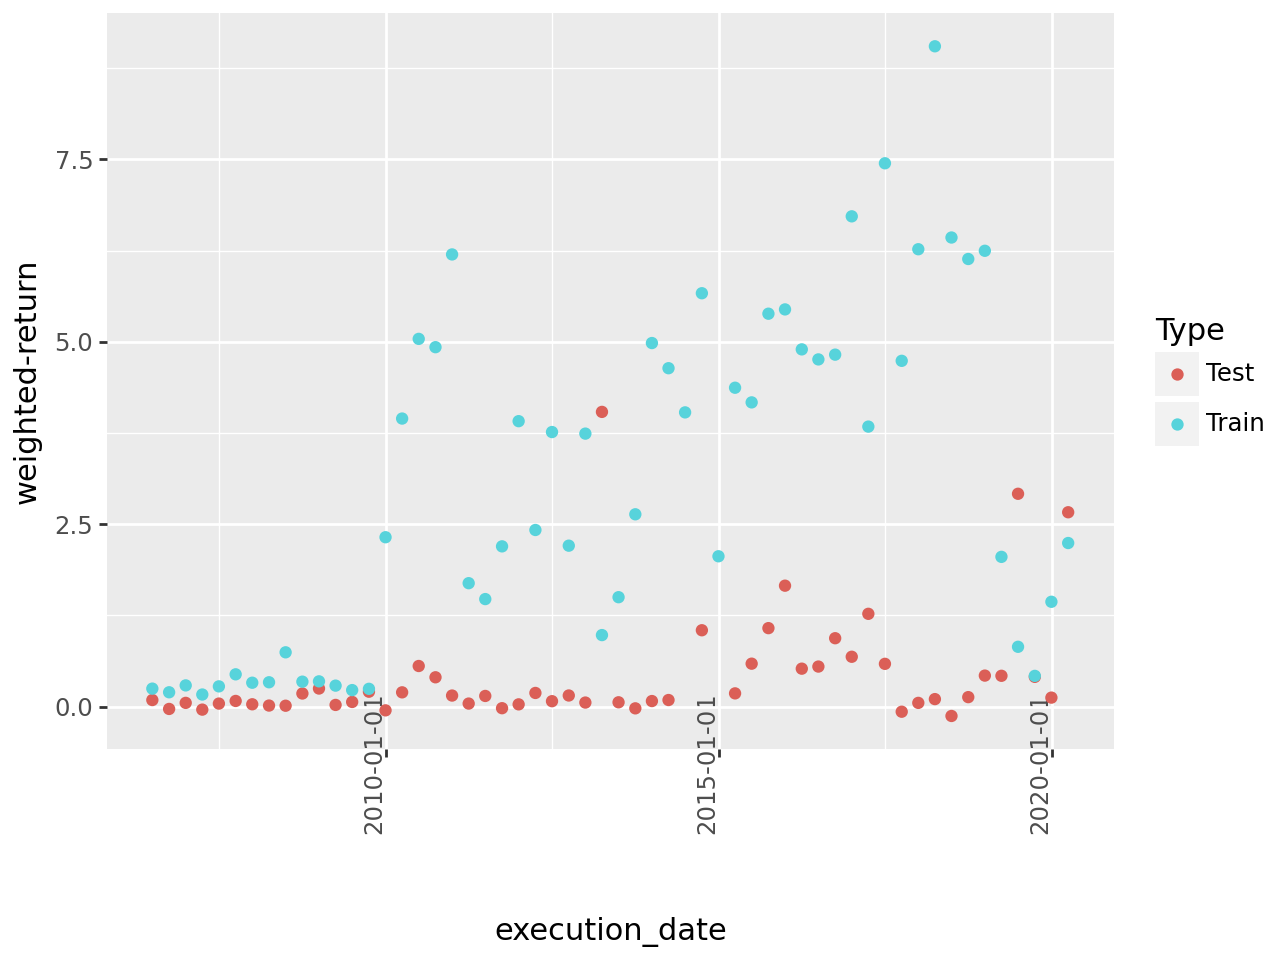

In [99]:
(ggplot(combined_data, aes(x='execution_date', y='weighted-return', color='Type'))
     + geom_point()
     + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1)))

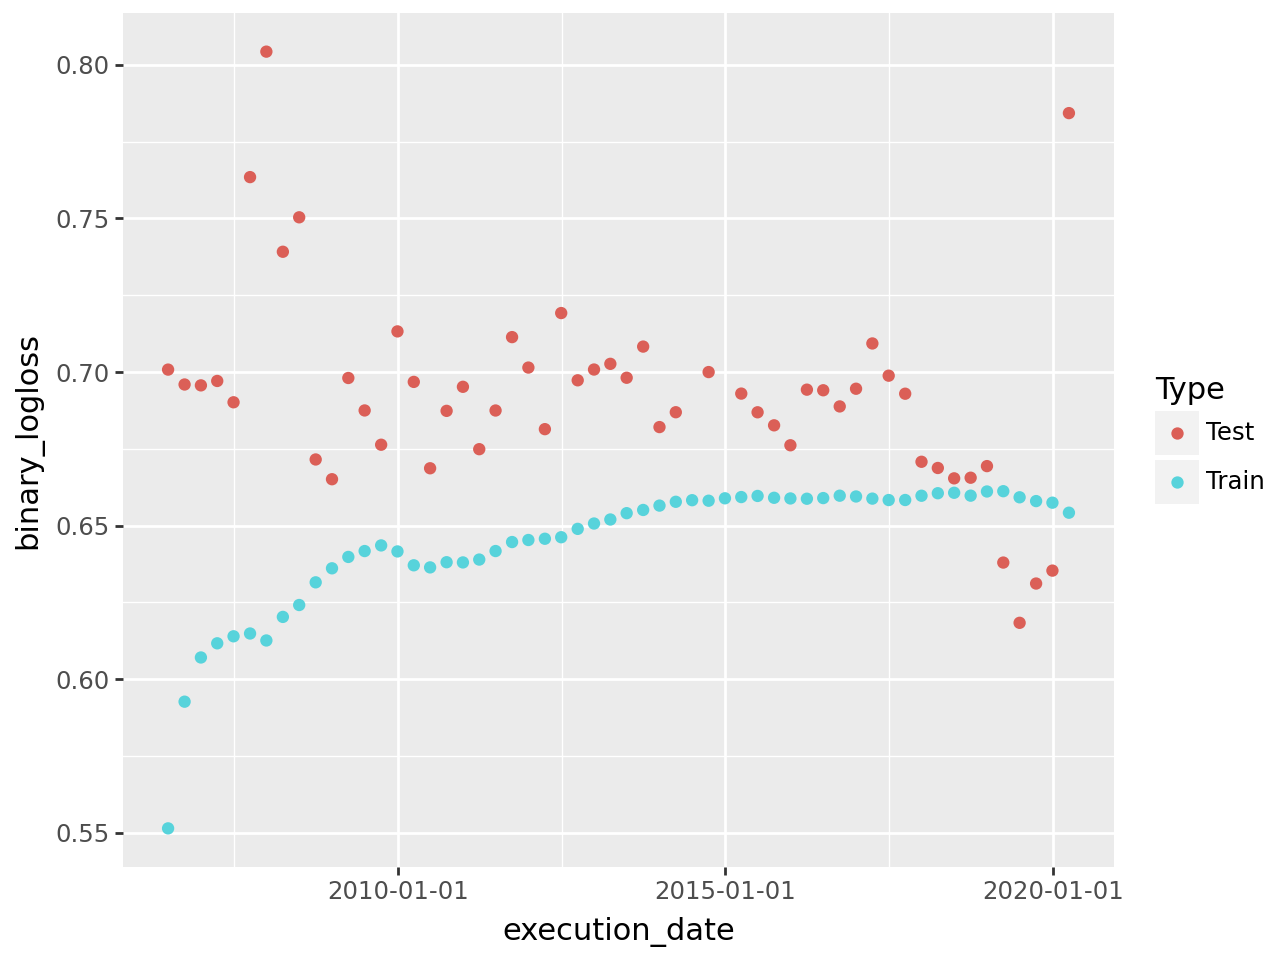

In [100]:
p = ggplot(combined_data) + geom_point(aes(x='execution_date', y='binary_logloss', colour='Type'))
p  

The fact that lower parameters improve the model can be confirmed. Let's try to iterate between ranges of parametes to optimize the model:

In [57]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

n_estimators = 30
num_leaves_range = [2, 5, 10]
max_depth_range = [1, 3, 4]
min_data_in_leaf_range = [60, 70, 80]

best_params = {}
best_score = float('inf')

for num_leaves in num_leaves_range:
    for max_depth in max_depth_range:
        for min_data_in_leaf in min_data_in_leaf_range:
            print(f"Testing n_estimators={n_estimators}, num_leaves={num_leaves}, max_depth={max_depth}, min_data_in_leaf={min_data_in_leaf}")
            temp_all_results = {}
            temp_all_predicted_tickers_list = []
            temp_all_models = {}
            for i, execution_date in enumerate(execution_dates):
                if i % 4 == 0:  # Only run for every 4th execution date
                    temp_all_results, temp_all_predicted_tickers_list, temp_all_models, model, X_train, X_test = run_model_for_execution_date(
                        execution_date, temp_all_results, temp_all_predicted_tickers_list, temp_all_models, n_estimators, num_leaves, max_depth, min_data_in_leaf, False
                    )
            avg_logloss = np.mean([np.mean(result['valid_0']['binary_logloss']) for result in temp_all_results.values()])
            print(f"Average logloss: {avg_logloss}")
            if avg_logloss < best_score:
                best_score = avg_logloss
                best_params = {
                    "n_estimators": n_estimators,
                    "num_leaves": num_leaves,
                    "max_depth": max_depth,
                    "min_data_in_leaf": min_data_in_leaf
                }
                all_results = temp_all_results
                all_predicted_tickers_list = temp_all_predicted_tickers_list
                all_models = temp_all_models

all_predicted_tickers = pd.concat(all_predicted_tickers_list)

print(f"Best params: {best_params} with average logloss: {best_score}")

Testing n_estimators=30, num_leaves=2, max_depth=1, min_data_in_leaf=60
Average logloss: 0.6932316522305318
Testing n_estimators=30, num_leaves=2, max_depth=1, min_data_in_leaf=70
Average logloss: 0.6932276648315466
Testing n_estimators=30, num_leaves=2, max_depth=1, min_data_in_leaf=80
Average logloss: 0.6932276648315467
Testing n_estimators=30, num_leaves=2, max_depth=3, min_data_in_leaf=60
Average logloss: 0.6932316522305318
Testing n_estimators=30, num_leaves=2, max_depth=3, min_data_in_leaf=70
Average logloss: 0.6932276648315466
Testing n_estimators=30, num_leaves=2, max_depth=3, min_data_in_leaf=80
Average logloss: 0.6932276648315466
Testing n_estimators=30, num_leaves=2, max_depth=4, min_data_in_leaf=60
Average logloss: 0.693231652230532
Testing n_estimators=30, num_leaves=2, max_depth=4, min_data_in_leaf=70
Average logloss: 0.6932276648315466
Testing n_estimators=30, num_leaves=2, max_depth=4, min_data_in_leaf=80
Average logloss: 0.6932276648315466
Testing n_estimators=30, num_

The parameters of the model have been optimized among the given values provided by us. These parameters could be optimized better, but we are going to consider it good for this exercise. The chosen parameters are the following: 

In [58]:
n_estimators = 30
num_leaves = 10
max_depth = 3
min_data_in_leaf = 70

In [59]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    #print(model)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,num_leaves,max_depth,min_data_in_leaf,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

In [60]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

test_results_final_tree['Type'] = 'Test'
train_results_final_tree['Type'] = 'Train'

combined_data = pd.concat([test_results_final_tree, train_results_final_tree])
combined_data['execution_date'] = pd.to_datetime(combined_data['execution_date'])
combined_data = combined_data[combined_data['weighted-return'] <= 60]

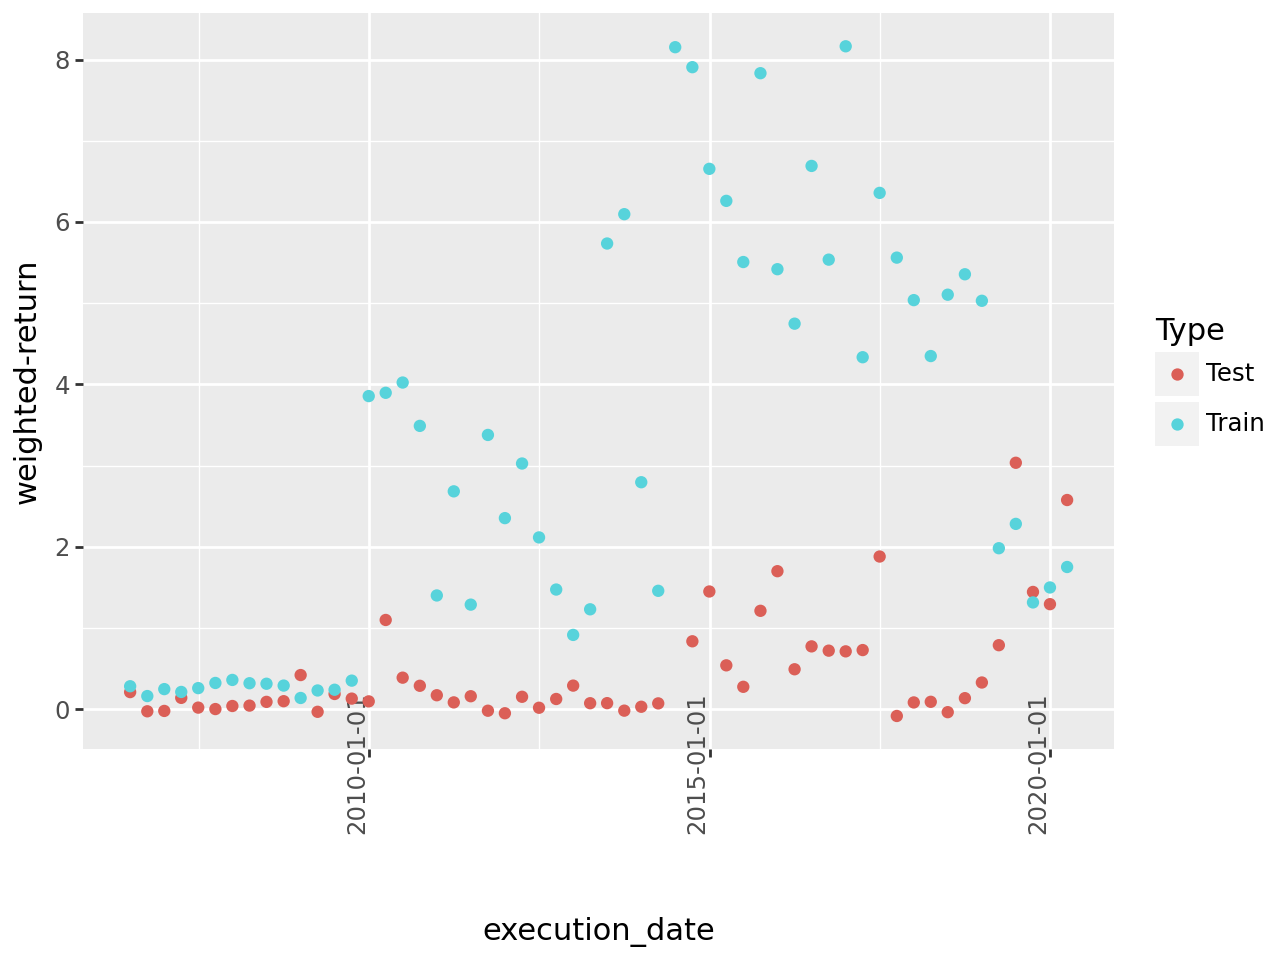

In [61]:
(ggplot(combined_data, aes(x='execution_date', y='weighted-return', color='Type'))
     + geom_point()
     + theme(axis_text_x=element_text(angle=90, vjust=0.5, hjust=1)))

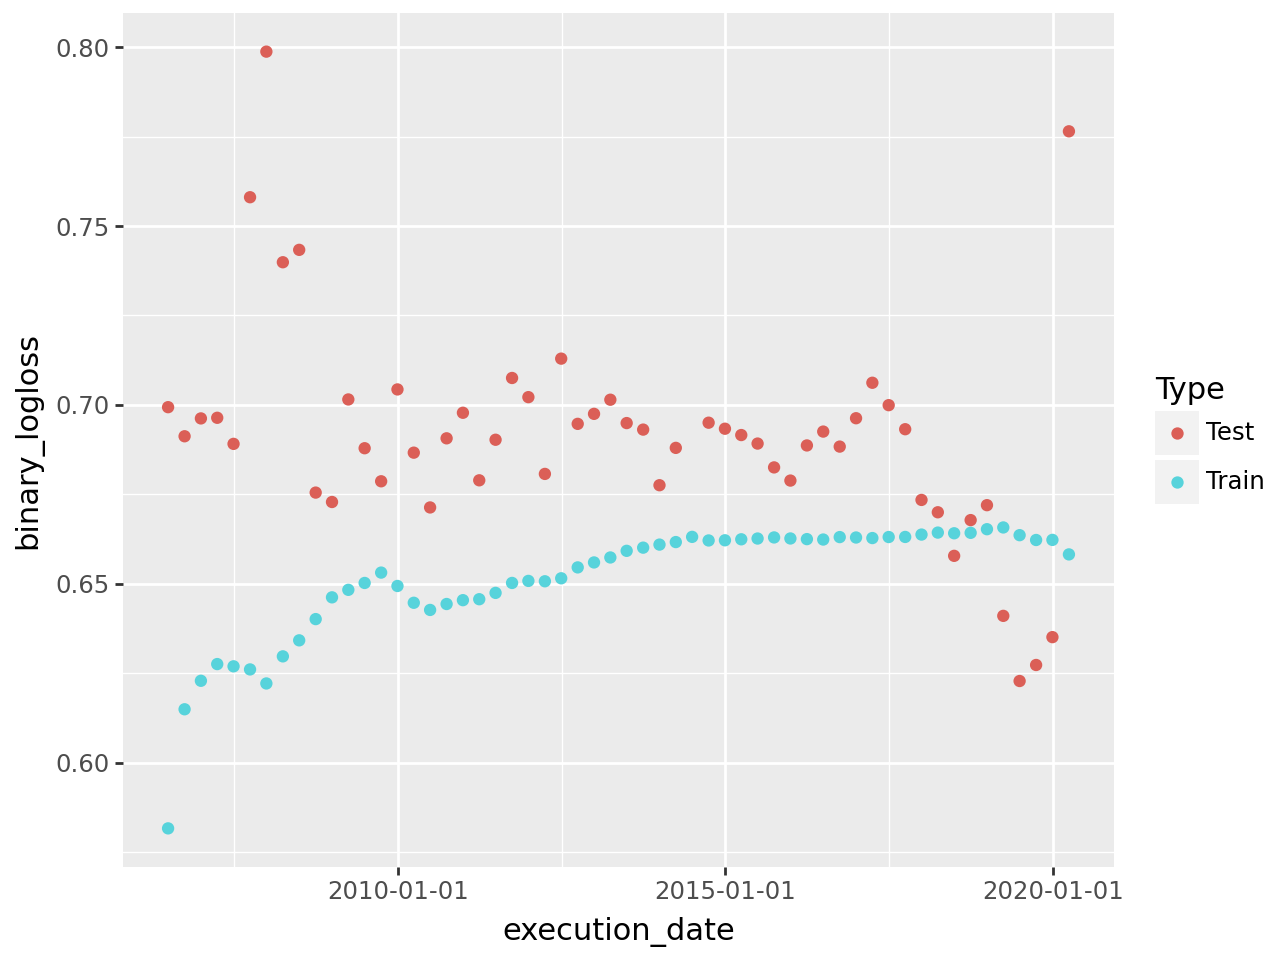

In [62]:
p = ggplot(combined_data) + geom_point(aes(x='execution_date', y='binary_logloss', colour='Type'))
p  

Weighted-return is still more disperse in train that in test. Model can be improved more in this sense. However, we managed to decrease logloss values in test, improving the predicting performance of the model. 

#### Conclusions:

Summary:
* At first instance, model varied much on its results between train and test. Other visualizations were used to understand if the algorithm was learning correctly. Train results showed more dispersion and higher weighted-return values and binari-logloss showed the model prediction was not good enough. We could say the model seemed to have high variance.
* By checking suspicious features, high correlated variables were deleted from the model. Besides that, features that contained information beyond the scope of the problem were deleted. Feature reduction contributed to reduce the dimensionality of the model, which usually translates into higher performance. However, we found out that close_0 variable (price of stock at execution date) had a huge importance on the prediction output. 
* Finally, parameters such us n_estimators, num_leaves, max_depth and min_data_in_leaf were tuned aiming to improve the performance of the model. Since model had high variance, lower parameters improved the model performance. These parameters were optimized. as a result, Weighted-return was still more disperse in train that in test, but logloss values were decreased in test, improving the predicting performance of the model.

Other alternatives to improve the model:
* Use other metrics to evaluate the algorithm. Try low level ones.
* Try to see if there is a lot of noise between different trainings
* Change the number of quarters to train in the past